In [59]:
import numpy as np  
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [60]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS=80

In [61]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Masked Gesture Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 14057 files belonging to 11 classes.


In [62]:
class_names = dataset.class_names
class_names

['1finger',
 '2finger',
 '3finger',
 'C',
 'ThumbRight',
 'fingersclosein',
 'italydown',
 'kitli',
 'pinky',
 'spreadoutpalm',
 'yoyo']

In [63]:
len(dataset)

440

In [64]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[ 8  4  6  3  5  6  4  3  9  0 10  7  7  7  8  1  3  1  6  2  4 10  5  6
  0  3  6  8  5  8  5  5]


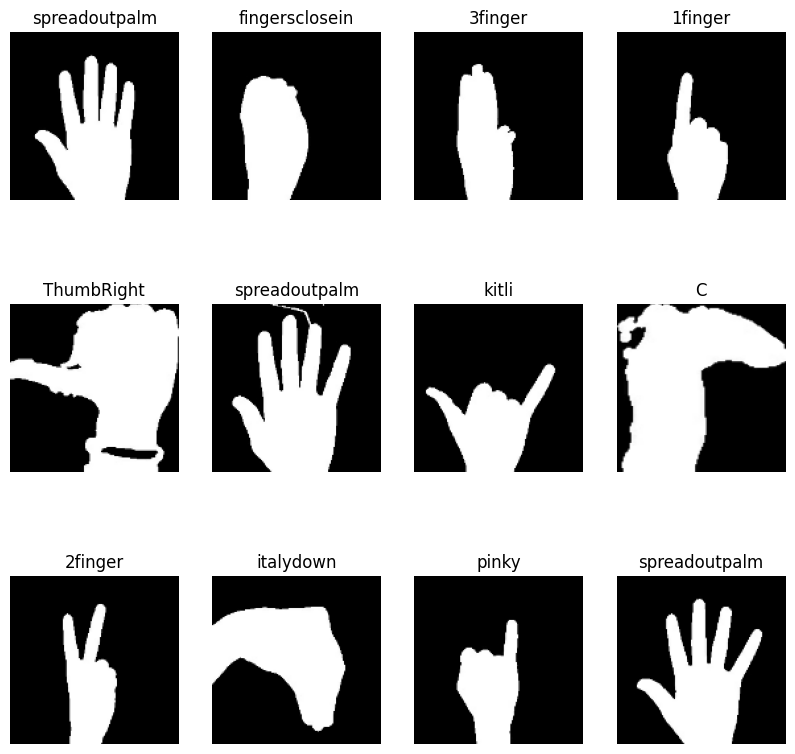

In [65]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [66]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[7][2])

tf.Tensor(
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+

In [80]:
train_ds = dataset.take(352)
len(train_ds)
print(train_ds)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [81]:
test_ds = dataset.skip(352)
len(test_ds)

88

In [82]:
val_size=0.1
len(dataset)*val_size

44.0

In [83]:
val_ds = test_ds.take(44)
len(val_ds)

44

In [84]:
test_ds = test_ds.skip(44)
len(test_ds)

44

In [85]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [86]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [87]:
len(train_ds)

352

In [88]:
len(val_ds)

44

In [89]:
len(test_ds)

44

In [90]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [91]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [92]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [93]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [94]:
CHANNELS = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes = 11

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [95]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 sequential_4 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (32, 126, 126, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 63, 63, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (32, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 30, 30, 64)          0         
 g2D)                                                 

In [96]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [97]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
352/352 [==============================] - 131s 366ms/step - loss: 0.9093 - accuracy: 0.6838 - val_loss: 0.3410 - val_accuracy: 0.8917
Epoch 2/5
352/352 [==============================] - 123s 350ms/step - loss: 0.2043 - accuracy: 0.9338 - val_loss: 0.1060 - val_accuracy: 0.9653
Epoch 3/5
352/352 [==============================] - 127s 360ms/step - loss: 0.1135 - accuracy: 0.9621 - val_loss: 0.0853 - val_accuracy: 0.9726
Epoch 4/5
352/352 [==============================] - 140s 396ms/step - loss: 0.0829 - accuracy: 0.9707 - val_loss: 0.0887 - val_accuracy: 0.9697
Epoch 5/5
352/352 [==============================] - 136s 387ms/step - loss: 0.0656 - accuracy: 0.9785 - val_loss: 0.0489 - val_accuracy: 0.9870


In [ ]:
scores = model.evaluate(test_ds)  # We got test accuracy of 99%

In [99]:
scores

[0.03385743126273155, 0.9914772510528564]

In [100]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [101]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict


actual label: 1finger
1/1 [==============================] - 0s 156ms/step
predicted label: 1finger


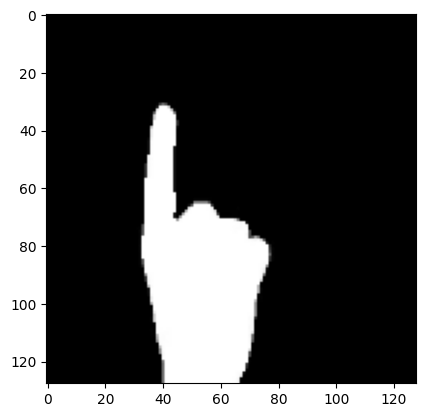

In [102]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [103]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 21ms/step


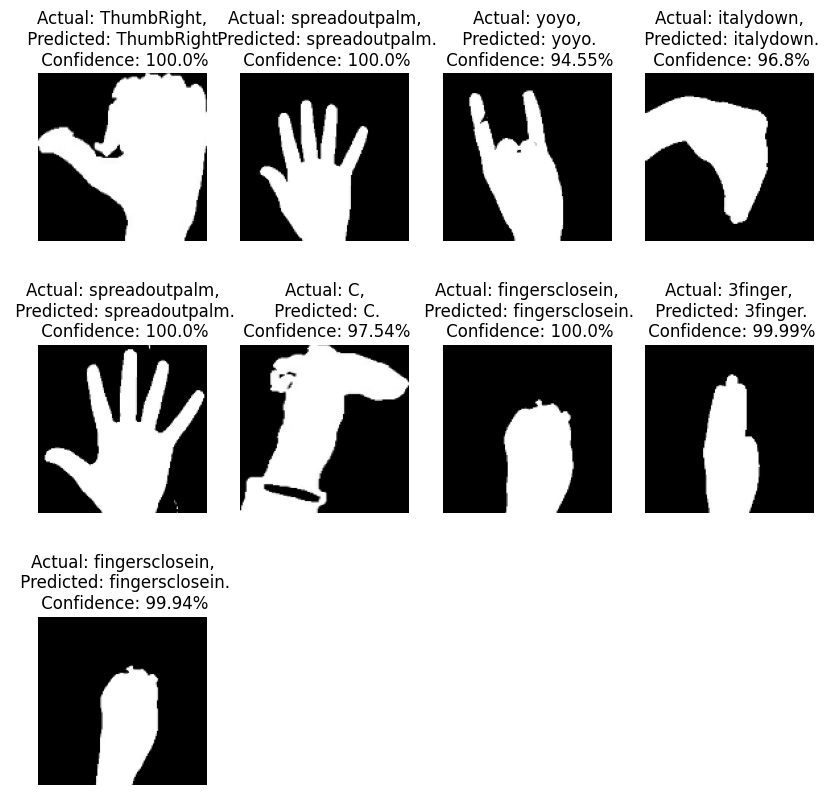

In [104]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [60]:
model_version = 5
model.save(f"../Models/{model_version}")  

INFO:tensorflow:Assets written to: ../Models/5/assets


INFO:tensorflow:Assets written to: ../Models/5/assets
